In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import arch

In [2]:
df = pd.read_csv(f'Data/BTCUSDT.csv')

In [4]:
btc = df[(df['Date']>'2018-03-31') & (df['Date']<'2020-07-02')]

rt       = df[(df['Date'] >= '2019-03-31') & (df['Date'] < '2019-10-01')]

btc.Date = pd.to_datetime(btc['Date'])
btc.set_index('Date',inplace=True)

C:\Users\Yassir EL-ORFI\AppData\Local\Temp\ipykernel_5824\305588769.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc.Date = pd.to_datetime(btc['Date'])


In [5]:
btc['returns']     = btc['Close'].pct_change()
btc['log_returns'] = np.log(btc['Close']).diff()
returnseries       = np.log(rt['Close']).diff()
btc = btc.dropna()

C:\Users\Yassir EL-ORFI\AppData\Local\Temp\ipykernel_5824\3922117124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['returns']     = btc['Close'].pct_change()
C:\Users\Yassir EL-ORFI\AppData\Local\Temp\ipykernel_5824\3922117124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['log_returns'] = np.log(btc['Close']).diff()


In [6]:
interval = 365
windows = [btc['log_returns'][slice(i,i+interval)]for i in range(len(btc)-interval)]

In [7]:
rows = []
tmp       = []
for window in windows:
    garch = arch.arch_model(window - window.mean(), mean="Zero")
    res   = garch.fit(disp="off")
    #print(res.summary())
    alpha0=res.params[0]
    alpha1=res.params[1]
    beta=res.params[2]
    volest = alpha0 + (alpha1 * window[-1]**2 + beta * res.conditional_volatility[-1]**2)
    forecast_date = window.index[-1]
    rows.append([forecast_date, np.sqrt(volest)])


c:\Users\Yassir EL-ORFI\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001048. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Yassir EL-ORFI\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:

In [8]:
garch = pd.DataFrame(rows, columns=['Date', 'vol'])#.set_index('Date')

In [9]:
d1, d2  = '2019-09-30', '2020-01-31'

#df      = df.reset_index()
df1     = garch[garch['Date'] <= d1]
df2     = garch[(garch['Date'] > d1) & (garch['Date'] <= d2)]
df3     = garch[garch['Date'] > d2]

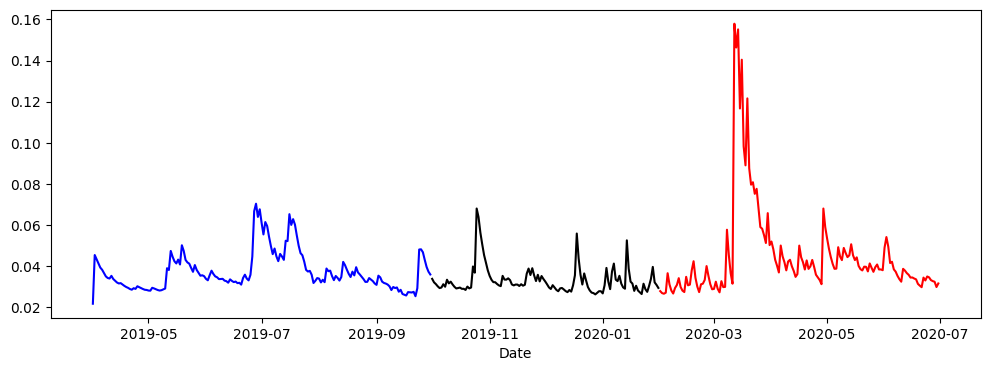

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df1['Date'], df1['vol'], c='b')
ax.plot(df2['Date'], df2['vol'], c='black')
ax.plot(df3['Date'], df3['vol'], c='r')
ax.set_xlabel("Date")
ax.set_ylabel("")
fig.savefig("garch_vol.png", transparent=True)